In [1]:
import logging
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
warnings.filterwarnings('ignore')

In [2]:
input = './data/corpus/corpus.csv.xz'
df = pd.read_csv(input, compression='xz')

In [3]:
sent = [sentence.split() for sentence in df['titulo']]
model = Word2Vec(sent, min_count=1,size= 50,workers=3, window =3, sg = 1)

WARNING - 07:14:16: consider setting layer size to a multiple of 4 for greater performance
INFO - 07:14:16: collecting all words and their counts
INFO - 07:14:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 07:14:17: collected 87462 word types from a corpus of 1959759 raw words and 8577 sentences
INFO - 07:14:17: Loading a fresh vocabulary
INFO - 07:14:17: effective_min_count=1 retains 87462 unique words (100% of original 87462, drops 0)
INFO - 07:14:17: effective_min_count=1 leaves 1959759 word corpus (100% of original 1959759, drops 0)
INFO - 07:14:17: deleting the raw counts dictionary of 87462 items
INFO - 07:14:17: sample=0.001 downsamples 27 most-common words
INFO - 07:14:17: downsampling leaves estimated 1634200 word corpus (83.4% of prior 1959759)
INFO - 07:14:17: estimated required memory for 87462 words and 50 dimensions: 78715800 bytes
INFO - 07:14:17: resetting layer weights
INFO - 07:14:37: training model with 3 workers on 87462 vocabulary and 

### T-SNE Plot

INFO - 07:15:06: precomputing L2-norms of word weight vectors


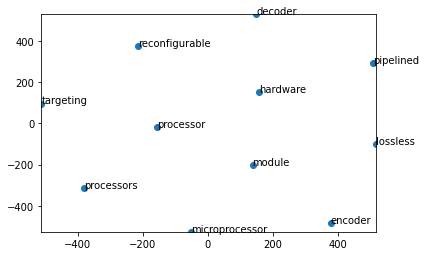

In [4]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

query = 'hardware'
display_closestwords_tsnescatterplot(model, query, 50)